# Load Data and Overview
---

In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, mean_squared_error, r2_score

In [265]:
# importing the tips dataset
diamonds_df = sns.load_dataset("diamonds")

#printing dataset header
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [266]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [267]:
# make categorical and numerical columns
cat_cols = diamonds_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = diamonds_df.select_dtypes(include=["number"]).drop('price', axis=1).columns.tolist()
print(cat_cols, num_cols, sep='\n')

['cut', 'color', 'clarity']
['carat', 'depth', 'table', 'x', 'y', 'z']


**Observations:**
- 3 Category columns
- 6 float columns
- 1 integer column

In [268]:
diamonds_df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


**Obersvations:**
- Looks like thgere is no missing values because every column has a count 53940, we can still check though to make sure.

In [269]:
diamonds_df.isna().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

- No missing value

In [270]:
# check for duplicated rows
print("Duplicate rows: ", diamonds_df.duplicated().sum(), "out of", diamonds_df.shape[0])

Duplicate rows:  146 out of 53940


In [271]:
# drop duplicates
diamonds_df.drop_duplicates(inplace=True)

# EDA
---

In [272]:
def dist_boxplot(data):
    for col in num_cols:
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        sns.boxplot(data=data, x=col, ax=ax[0])
        sns.histplot(data=data, x=col, ax=ax[1])
        plt.show()


### Univariate Analysis

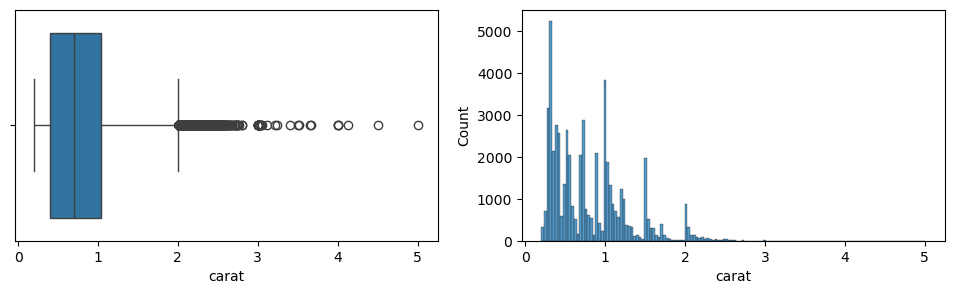

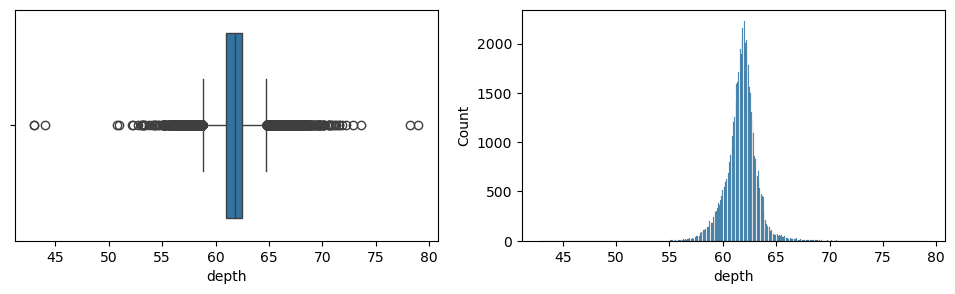

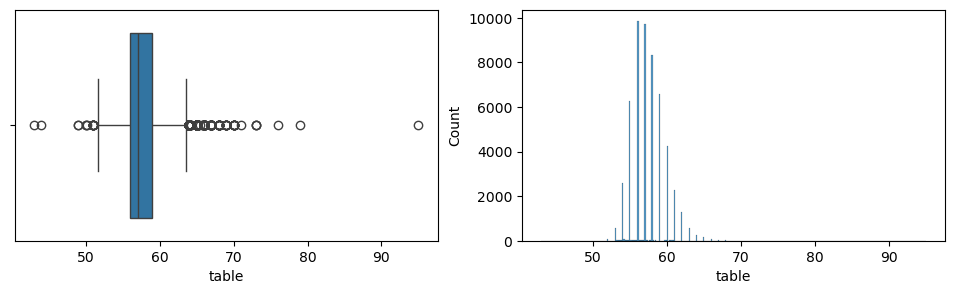

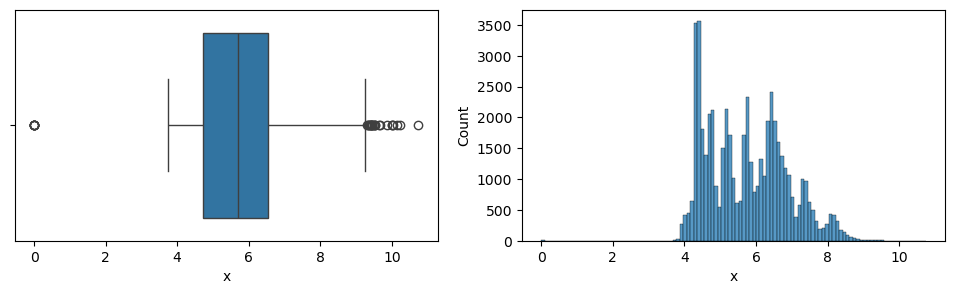

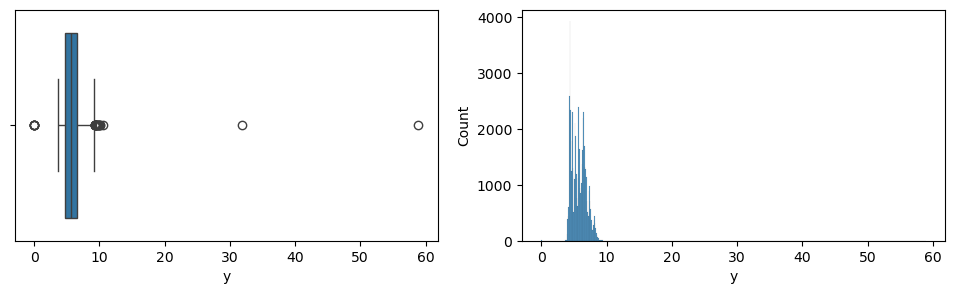

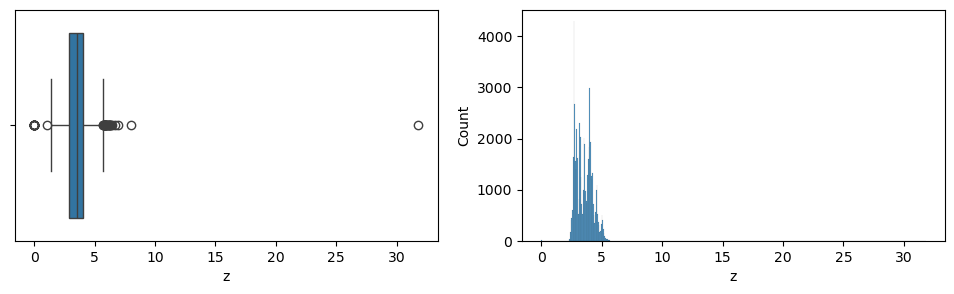

In [273]:
dist_boxplot(diamonds_df)

### Bivariate Analysis

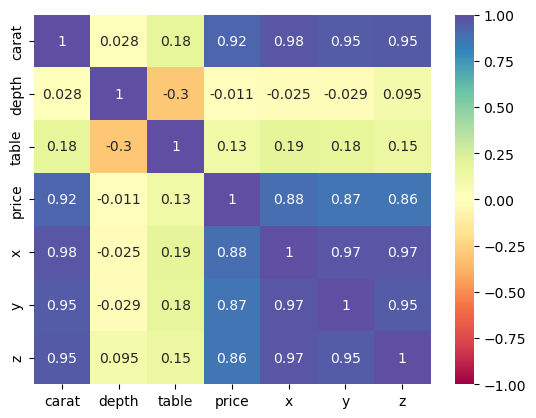

In [276]:
corr = diamonds_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, vmin=-1, center=0, vmax=1, cmap='Spectral')
plt.show()

In [277]:
def catplot(data):
    for col in cat_cols:
        plt.figure(figsize=(12, 7))
        ax = sns.countplot(data=data, x=col)
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.show()

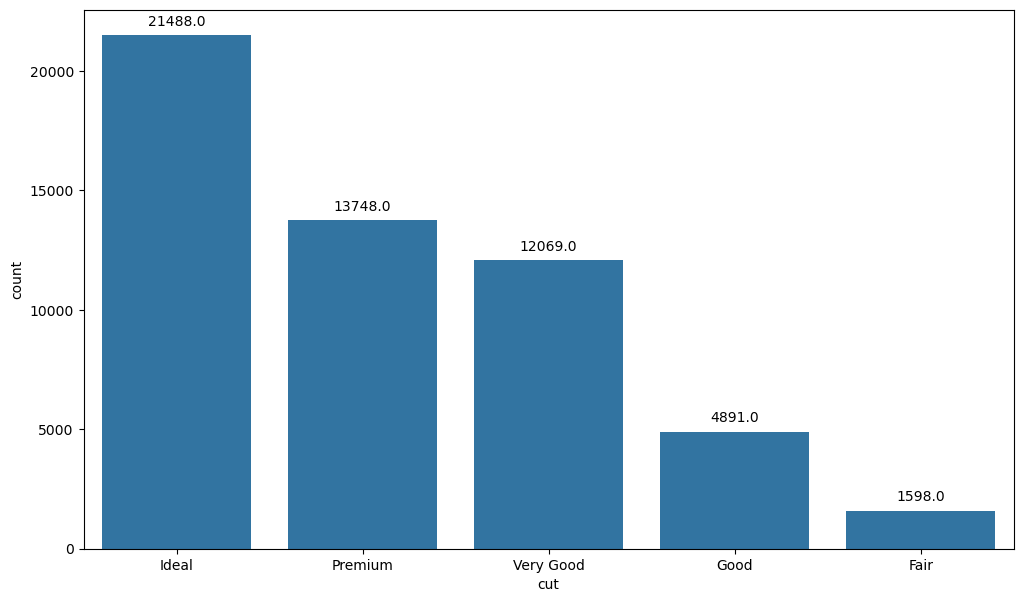

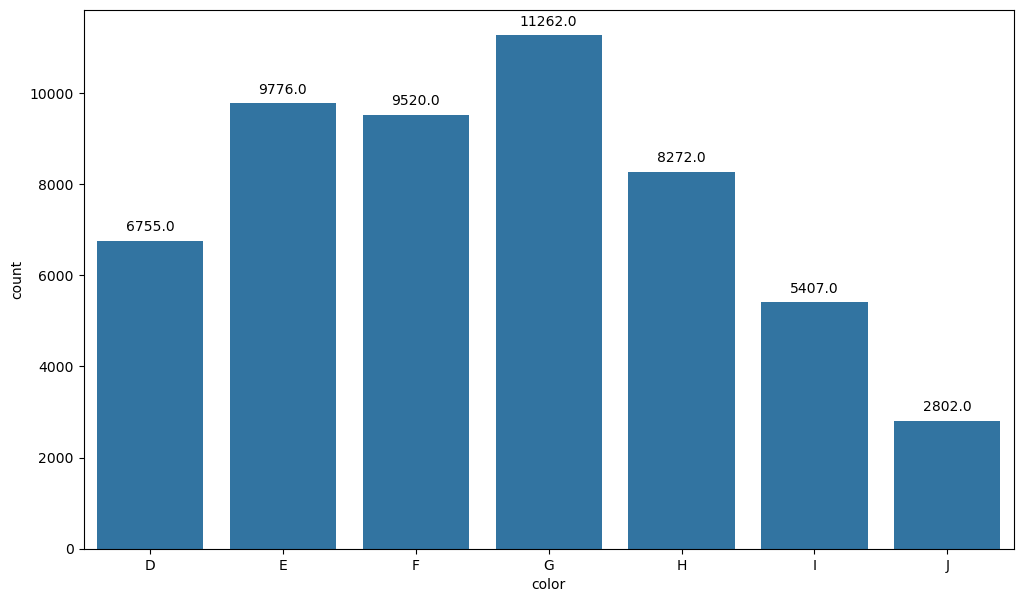

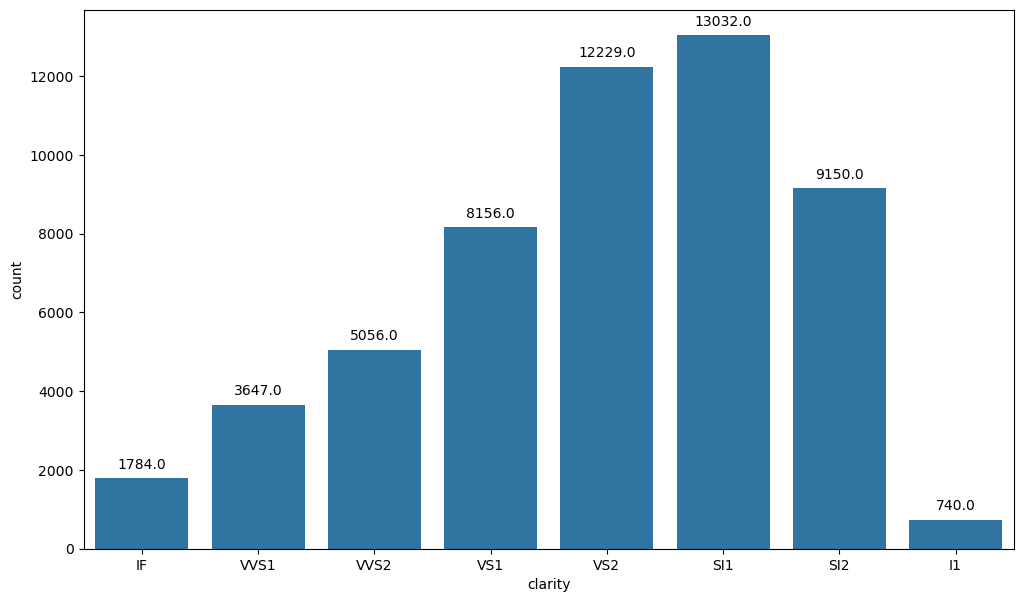

In [278]:
catplot(diamonds_df)

# Model Preparation
---

In [279]:
nums = diamonds_df.select_dtypes(include=['number'])
nums

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74


In [280]:
cats = diamonds_df.select_dtypes(include=['object', 'category'])
cats = pd.get_dummies(cats, drop_first=True)
cats

,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_E,color_F,color_G,color_H,color_I,color_J,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False
3,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
4,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
53936,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
53937,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
53938,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False


In [281]:
X = diamonds_df.drop('price', axis=1)
y = diamonds_df['price']

### Split data

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Scaling Data

In [330]:
# PIPELINE
# create preprocessor
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

# diamonds_processed = preprocessor.fit_transform(X_train, y_train)

In [333]:
# create pipelines
steps=[
    ('preprocessor', preprocessor),
    ('rfr', RandomForestRegressor(random_state=42))
]

pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat', OneHotEncoder(),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('rfr', RandomForestRegressor(random_state=42))])

### Performance metrics

In [302]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [303]:
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

In [304]:
# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    mse = mean_squared_error(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "MSE":mse,
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

### Random Forest Regression

In [334]:
pipe.score(X_test, y_test)

0.9821293760366193

In [335]:
model_performance_regression(pipe, X_test, y_test) # very good adj r squared as well

,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,272385.305301,521.905456,263.215054,0.982129,0.982114,6.526709


In [336]:
yhat2 = pipe.predict(X_test)
yhat2

array([ 1678.16,  3734.31,  1866.54, ...,   867.7 , 14839.48,  1022.37])

In [358]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_test

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

### Predicting the given characteristics 

In [349]:
X_temp = diamonds_df.drop('price', axis=1).copy()
temp = {
    "carat":[0.25],
    "cut":["Premium"],
    "clarity":X_train['clarity'].mode(),
    "color":["J"],
    "depth":[56.7],
    "table":[57.0],
    "x":[4.01],
    "y":[4.05],
    "z":[2.35]
}
df = pd.DataFrame(temp)
# X_temp = pd.concat([X_temp, df], ignore_index=True)
# X_temp = pd.get_dummies(X_temp, drop_first=True)
# X_temp = X_temp.tail(1)
# X_temp
df

,carat,cut,clarity,color,depth,table,x,y,z
0,0.25,Premium,SI1,J,56.7,57.0,4.01,4.05,2.35


In [352]:
# single_record = sc.transform(X_temp.values[-1].reshape(1, -1))
# X_temp = preprocessor.transform(X_temp)
predicted_price = pipe.predict(df.head(1))

# print(f"The predicted price with given characterics of a diamond is: ${np.round(predicted_price.item(), 2)}")
predicted_price

array([454.62])

In [295]:
!jupyter nbconvert --to html Midterm_RJ.ipynb

[NbConvertApp] Converting notebook Midterm_RJ.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 661775 bytes to Midterm_RJ.html
